# Section 2: Exploring Satellite Image
Author: Meixu(May) Chen           

## Overview

Objectives:

* Understand the basic components of a raster dataset and how to access them by Python
* Perform numerical operations on a specific neighbourhood
* Be able to use an unsupervised clssification method to cluster spectral statistical features of your data

The python libraries used for this tutorial: 
* [Rasterio](http://rasterio.readthedocs.io/en/latest/quickstart.html): provides convenient plotting routines based on matplotlib; provides the same functionality as GDAL in many cases, but with more pythonic interface
* [Numpy](http://www.numpy.org/): fundamental package for scientific computing with Python, which contains a powerful N-dimensional array object
* [Matplotlib](https://matplotlib.org/): a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.
* [Geopandas](http://geopandas.org/index.html): geospatial data analysis
* [Scikit-learn](http://scikit-learn.org/stable/index.html): machine learning in Python, which used as simple tools for data mining and data analysis
* [Scikit-image](http://scikit-image.org/): a collection of algorithms for Image processing 
* [Rasterstats](https://pythonhosted.org/rasterstats/): summarizes geospatial raster datasets based on vector geometries
* [Glob](https://pymotw.com/2/glob/): filename pattern matching

## Get familiar with the 'rasterio' library

In [1]:
%matplotlib inline

# Import all libraries used in this tutorial
import rasterio as rio
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.mask import mask
from skimage import exposure
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
from rasterstats import zonal_stats
import glob

* Open Raster data

In [2]:
rs = rio.open('../data/RGB_stacked.TIF')

* Get the attributes


In [3]:
#get the metadata from the raster file
rs.meta

{'count': 3,
 'crs': CRS({'init': u'epsg:27700'}),
 'driver': u'GTiff',
 'dtype': 'uint16',
 'height': 985,
 'nodata': 0.0,
 'transform': Affine(30.005551366564468, 0.0, 317322.55051205296,
        0.0, -30.005551366564468, 399776.17929402104),
 'width': 931}

In [4]:
# Get one attribute from data, e.g. The transform attribute 
# It is an affine transformation matrix that maps pixel locations 
# in (row, col) coordinates to (x, y) spatial positions.
rs.transform

Affine(30.005551366564468, 0.0, 317322.55051205296,
       0.0, -30.005551366564468, 399776.17929402104)

In [5]:
# Get its spatial extent 
rs.bounds

BoundingBox(left=317322.55051205296, bottom=370220.71119795507, right=345257.71883432445, top=399776.17929402104)

In [6]:
# Get its rows and columns
print (rs.height)
print (rs.width)

985
931


* Read the data

Each band is an array of values representing the partial distribution of a single variable in 2-dimensional (2D) space. 

In [7]:
rs.read(1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [8]:
# Counts the number of non-zero values in the array
np.count_nonzero(rs.read(1))

867622

## Visualisation

* Plot each band of the satellite image

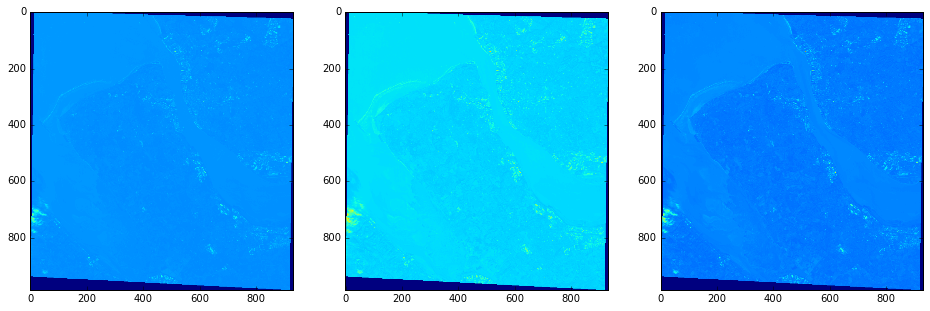

In [9]:
f, ax = plt.subplots(1, 3, figsize=(16, 8))
for i in range(3):
    ax[i].imshow(rs.read(i+1))

* Plot all bands at one map

In [10]:
#read vector data in
liv_lsoa = gpd.read_file('../data/liverpool_LSOA.geojson')
liv_lsoa.head()

,ahah,dent_d,e_dom,ed_d,ffood_d,gamb_d,geometry,gpp_d,green900,h_dom,leis_d,lsoa11cd,no2,off2_d,pharm_d,pm10,pubs2_d,r_dom,so2,tobac_d
0,26.848152,0.498800,46.285488,1.287320,0.780400,1.022400,"POLYGON ((336218.1339999995 390011.6269999991,...",0.426000,0.230025,1.809185,1.539200,E01006512,14.792113,1.012400,0.530000,11.971486,0.669600,33.208541,1.660273,1.502000
1,46.285461,0.380110,48.318284,1.353440,0.161538,0.334725,"POLYGON ((336120.5150000003 390365.2990000009,...",0.249780,0.204311,0.300638,0.683077,E01006513,14.818730,0.365934,0.389121,11.992123,0.132527,91.630940,1.667497,0.591209
2,33.184663,0.448696,46.111132,1.573348,0.541087,0.625652,"POLYGON ((335777.9999999994 389780.9999999992,...",0.330652,0.215201,0.933787,0.980435,E01006514,14.570516,0.586087,0.447391,11.873392,0.335000,53.486369,1.664449,0.953478
3,30.212842,0.864237,48.931073,2.361593,0.623051,0.728644,"POLYGON ((335187.0000000002 389431.9349999998,...",0.614068,0.150732,3.317211,0.488136,E01006515,14.410901,1.212881,0.750847,11.794274,0.558305,39.205261,1.653070,1.242373
4,22.832487,0.870465,42.900384,2.494605,1.354651,0.752326,"POLYGON ((335667.9610000005 388890.2179999998,...",0.865581,0.249174,3.895044,0.960233,E01006518,14.345118,1.767907,0.419767,11.765324,1.363953,22.275894,1.661707,1.746279


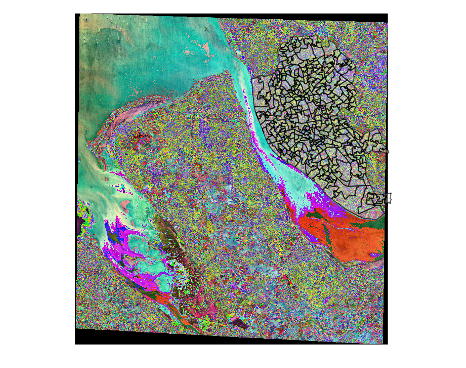

In [11]:
f, ax = plt.subplots(figsize=(9, 6))
#Stack RGB bands 
rgb = np.dstack((rs.read(i).astype(np.float) for i in range(3,0,-1)))
# Re-arrange bounding box to plot
bounds = (rs.bounds.left, rs.bounds.right, \
          rs.bounds.bottom, rs.bounds.top)
#plot raster data
ax.imshow(rgb,extent = bounds,alpha = 1)
#plot liverpool LSOA
liv_lsoa.plot(alpha=0.3, color = 'w',linewidth = 0.6, ax = ax)
#remove the axis
ax.set_axis_off()
#show the figure
plt.show()

## Basic image processing 


* Improve visualisation, see documentation [Histogram Equalization](http://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html?highlight=histogram) for more examples

* Convert color image into Grayscale

C:\Users\Meixu\Anaconda3\envs\gds\lib\site-packages\skimage\exposure\exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


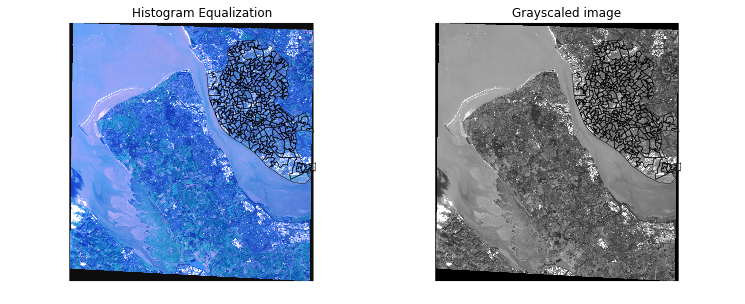

In [12]:
f, ax = plt.subplots(1,2,figsize = (12,6))
#Histogram Equalization to enhances an image with low contrast
equal_img = exposure.equalize_hist(rgb)
ax[0].imshow(equal_img, extent = bounds)
liv_lsoa.plot(alpha=0.2, color = 'w',linewidth = 0.5, ax = ax[0])
ax[0].set_axis_off()
ax[0].set_title('Histogram Equalization')
# Convert color image to grayscale
gray_image = rgb2gray(equal_img)
ax[1].imshow(gray_image,extent = bounds, cmap = 'gray')
liv_lsoa.plot(alpha=0.2, color = 'w',linewidth = 0.5, ax = ax[1])
ax[1].set_axis_off()
ax[1].set_title('Grayscaled image')
plt.show()

* Extract neighbourhood from image by vector data

In [13]:
#get coordinate info from vector data
features = [liv_lsoa.__geo_interface__['features'][i]['geometry'] 
            for i in range(len(liv_lsoa))]

In [14]:
#crop image into liverpool
out_image, out_transform = mask(rs, features, crop=True)

In [15]:
#have a look at the masked_array of one band
out_image[0]

masked_array(data =
 [[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]],
             mask =
 [[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]],
       fill_value = 0)

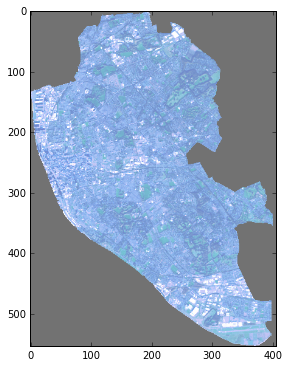

In [16]:
#plot the neighbourhood
plt.figure(figsize = (9,6))
#stack cropped bands
cropped_img = np.dstack((out_image[i].data for i in range(2,-1,-1)))
#image enhancement
equ_img = exposure.equalize_hist(cropped_img)
plt.imshow(equ_img)

* Get the spectral statistical features from the image

In [17]:
#locate to the dictionary with raster files
files = glob.glob(r'../data/RGB_bands/' + "*.TIF")
#calculate the zonal stats of raster by vector
stats = [zonal_stats('../data/liverpool_LSOA.geojson', f, stats='mean') for f in files]
#create dataframe for each band
df = [pd.DataFrame(stats[i]) for i in range(3)]
#combine all dataframes into one
band_sta = pd.concat(df,axis = 1)
#rename the columns
band_sta.columns = ['band'+ str(i+2) + '_' + 'mean' for i in range(3)]

band_sta.head()

,band2_mean,band3_mean,band4_mean
0,6976.063091,6331.716088,6100.299685
1,6995.311502,6354.611821,6136.699681
2,6909.189655,6260.668966,6014.968966
3,6972.178218,6344.086634,6122.732673
4,6902.133333,6271.584314,6048.400000


## Image classification: Characterising neighbourhood in Liverpool 

* Use unsupervised learning method K-means to group the spectral features

In [18]:
k = 5
#put the class labels in a series
cls = pd.Series(KMeans(n_clusters=k,random_state=10).fit_predict(band_sta))

In [19]:
cls.head()

0    2
1    2
2    0
3    2
4    0
dtype: int32

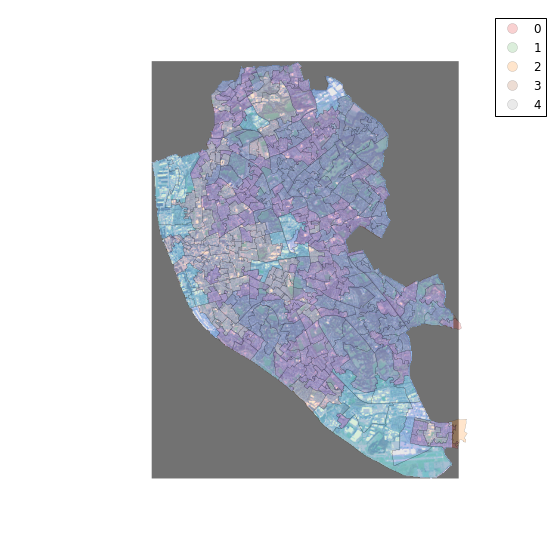

In [20]:
f, ax = plt.subplots(1, figsize=(9, 9))
# re-arrange bounding box to plot
bounds = rio.transform.array_bounds(equ_img.shape[0],equ_img.shape[1],out_transform)
#adjust the order to make the bounds as west,east,south,north
bounds = bounds[0],bounds[2],bounds[1],bounds[3]
# show image in the spatial extent
ax.imshow(equ_img,extent = bounds,alpha = 1)
# show classes
liv_lsoa.assign(lbls=cls)\
     .plot(column='lbls', categorical=True,linewidth=0.1, alpha=0.2, ax=ax,legend = True)
ax.axis('off')
ax.axis('equal')
plt.show()

* Interact with the number of k

In [21]:
def plot_kmeans(k):
    '''
    k: the number of k for the cluster
    '''
    cls = pd.Series(KMeans(n_clusters=k,random_state=10).fit_predict(band_sta))
    f, ax = plt.subplots(1, figsize=(9, 9))
    # show image in the spatial extent
    ax.imshow(equ_img,extent = bounds,alpha = 1)
    # show classes
    liv_lsoa.assign(lbls=cls)\
         .plot(column='lbls', categorical=True,linewidth=0.1, alpha=0.2, ax=ax,legend = True)
    ax.axis('off')
    ax.axis('equal')
    
    return plt.show()

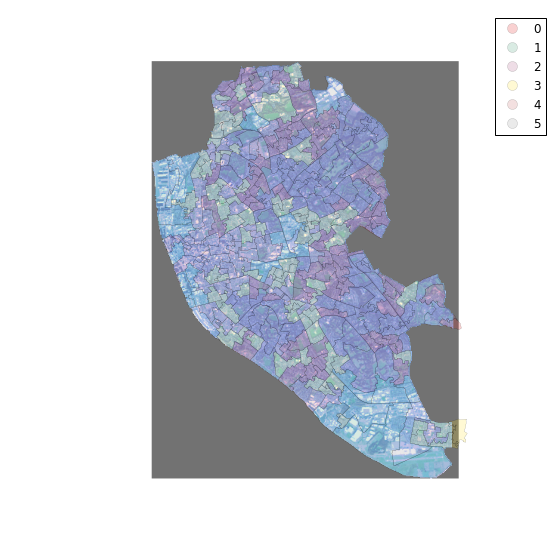

<function __main__.plot_kmeans>

In [22]:
from ipywidgets import interact
interact(plot_kmeans, k = (2,10,1))